In [60]:
import numpy as np
import pandas as pd
import xarray as xr
# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
# from meteostat import Hourly,Point
from sklearn.metrics import mean_absolute_percentage_error
# from statsmodels.tsa.stattools import adfuller
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from utils import *
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Import

In [92]:
import pandas as pd
import numpy as np


class Dataset:
    """
    A class that represents a dataset and provides methods for data preprocessing and feature engineering.

    Parameters:
                    df (pd.DataFrame): The input DataFrame containing the dataset.

    Methods:
                    create_y(df: pd.DataFrame, delay: int) -> pd.DataFrame:
                                    Creates a lagged target variable DataFrame.

                    apply_rolling_window(df: pd.DataFrame, data: str, roll_time: int, window_function: callable):
                                    Applies a rolling window function to a specific column of the DataFrame.

                    add_last_t(df: pd.DataFrame, data: str, step: int = 2):
                                    Adds the last T steps of a specific column as new features to the DataFrame.

                    add_seasonal_feat(df: pd.DataFrame):
                                    Adds seasonal features based on time information to the DataFrame.

                    create_dataset(delay: int, roll_time: int, rolling_features: list = []) -> pd.DataFrame:
                                    Creates the final dataset with lagged features, rolling window features, and additional features.
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df

    def fill_nan(self, fields):  # TODO add delayed Nan handling
        for f in fields:  # fill na with previous value
            self.df[f] = self.df[f].ffill()
            self.df[f] = self.df[f].fillna(
                self.df[f].mean()
            )  # fill remaining na with mean

    def drop_nan(self, fields):
        self.df = self.df.drop(columns=fields)

    def sample(self, n: int):
        self.df = self.df.iloc[::n, :]  # sample every nth row

    def create_y(self, df: pd.DataFrame, delay: int) -> pd.DataFrame:
        """
        Create a lagged target variable DataFrame.

        Parameters:
                        df (pd.DataFrame): The input DataFrame.
                        delay (int): The number of time steps to lag the data.

        Returns:
                        pd.DataFrame: The DataFrame with the lagged target variable.
        """
        y = pd.DataFrame()
        y["y"] = df.shift(-delay)
        y.dropna(inplace=True)
        return y

    def apply_rolling_window(
        self, df: pd.DataFrame, data: str, roll_time: int, window_function: callable
    ):
        """
        Applies a rolling window function to a specific column of the DataFrame.

        Parameters:
                        df (pd.DataFrame): The input DataFrame.
                        data (str): The column name on which to apply the rolling window function.
                        roll_time (int): The window size for the rolling window function.
                        window_function (callable): The function to apply on the rolling window.

        Returns:
                        pd.DataFrame: The DataFrame with the applied rolling window function.
        """
        if not callable(window_function):
            raise ValueError("window_function must be a callable function")

        df[f"rolling_{window_function.__name__}_{data}"] = (
            df[data].rolling(window=roll_time).apply(window_function)
        )
        df.fillna(0, inplace=True)
        return df

    def add_last_t(self, df: pd.DataFrame, data: str, step: int = 2):
        """
        Adds the last T steps of a specific column as new features to the DataFrame.

        Parameters:
                        df (pd.DataFrame): The input DataFrame.
                        data (str): The column name for which to add the last T steps as new features.
                        step (int): The number of steps to consider.

        Returns:
                        None
        """
        for i in range(1, step + 1):
            df[f"{data}_last_{i}_step"] = df[data].shift(i)
            df[f"{data}_last_{i}_step"].fillna(0)

    def get_df(self):
        return self.df

    def add_seasonal_feat(self, df: pd.DataFrame):
        """
        Adds seasonal features based on time information to the DataFrame.

        Parameters:
                        df (pd.DataFrame): The input DataFrame.

        Returns:
                        None
        """
        df["hour_sin"] = np.sin(df.Time.dt.hour / 23 * 2 * np.pi)
        df["hour_cos"] = np.cos(df.Time.dt.hour / 23 * 2 * np.pi)
        df["week_sin"] = np.sin((df.Time.dt.week / 52) * 2 * np.pi)
        df["week_cos"] = np.cos((df.Time.dt.week / 52) * 2 * np.pi)

    def create_dataset(
        self, df, window_size, prediction_horizon, shuffle=False, test_split=0.2,val_split=0.2
    ):  # TODO vectorize
        # TODO add index to df
        # TODO multistep flattener
        def create_xy(df,target_col="active_power_total"):
            X = []
            y = []
            for i in range(0, len(df)):
                if (
                    len(df[(i + window_size) : (i + window_size + prediction_horizon)])
                    < prediction_horizon
                ):
                    break
                X.append(df[target_col][i : (i + window_size)])
                y.append(df[target_col][(i + window_size) : (i + window_size + prediction_horizon)])
            X = np.array(X)

            #join old features with X
            X = np.concatenate((X,df.iloc[window_size:len(X)+window_size,:].drop(target_col, axis=1) ), axis=1)
            y = np.array(y)
            return X, y

        train_split = len(df) - int(len(df) * test_split) - int(len(df) * val_split)
        val_split = len(df) - int(len(df) * test_split)
        train_df = df[:train_split]
        val_df = df[train_split - window_size :val_split]
        test_df = df[val_split - window_size :]

        train_x, train_y = create_xy(train_df)
        val_x, val_y = create_xy(val_df)
        test_x, test_y = create_xy(test_df)

        names = [f'lag_{i}' for i in range(1,window_size+1)]
        names.extend(list(df.drop("active_power_total", axis=1).columns))

        return train_x,val_x, test_x, train_y,val_y, test_y,names


In [74]:
from typing import Any
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from utils import score_function
import matplotlib.pyplot as plt


class Model:
    def __init__(self, model_function="cb", params={}) -> None:
        self.model_function = (
            CatBoostRegressor if model_function == "cb" else LGBMRegressor
        )
        self.params = params

    def train(
        self,
        train_x: pd.DataFrame,
        train_y: pd.DataFrame,
        val_x: pd.DataFrame,
        val_y: pd.DataFrame,
        multioutput=False,
        verbose=500,
    ):
        """
        Trains the model.

        Parameters:
                        train_x (pd.DataFrame): The input DataFrame.
                        train_y (pd.DataFrame): The output DataFrame.

        Returns:
                        None
        """

        if multioutput: # TODO  CB does not support multioutput valitdation
            self.model = MultiOutputRegressor(
                self.model_function()
            )
            self.model.fit(train_x, train_y,verbose=500)
        else:
            self.model = self.model_function(**self.params)
            self.model.fit(train_x, train_y, eval_set=(val_x, val_y),verbose=500)

    def predict(self, test_x: pd.DataFrame, prediction_type="one_shot") -> np.ndarray:
        if prediction_type == "one_shot":
            forecast = self.model.predict(test_x)
            # check wheter forecast is 2d or 1d
            if len(forecast.shape) == 2:
                forecast = forecast[:, -1]
            return forecast
        elif prediction_type == "recursive":
            print("Not implemented yet")
        else:
            print("Prediction type not recognized")

    def model_summarizer(
        self,
        val_x: pd.DataFrame,
        val_y: pd.DataFrame,
        test_x: pd.DataFrame,
        test_y: pd.DataFrame,
        plots=True,
        plot_steps=2000,
        feat_importance=True,
        feat_steps=15,
    ):
        val_pred, test_pred = self.predict(val_x), self.predict(test_x)
        # give assertion error if predictions are not 1d
        assert (
            len(val_pred.shape) == 1 and len(test_pred.shape) == 1
        ), "Predictions are not 1d"
        # give assertion error if the shape of the prediction is not the same as the shape of the test set
        if len(test_y.shape) != 1: # returning to original shape
            test_y = test_y[:, -1]
        if len(val_y.shape) != 1: # returning to original shape
            val_y = val_y[:, -1]

        val_mae, val_rmse, val_r2 = score_function(val_y, val_pred)
        test_mae, test_rmse, test_r2 = score_function(test_y, test_pred)
        # create a 2 row  dataframe to store the results, first row is for validation, second row is for test
        scores = pd.DataFrame(
            np.array([[val_mae, val_rmse, val_r2], [test_mae, test_rmse, test_r2]])
        )
        scores.columns = ["MAE", "RMSE", "R2"]
        scores.index = ["Validation", "Test"]
        print(scores)

        if plots:
            fig, axs = plt.subplots(2, 1, figsize=(10, 8))

            # Plot the validation predictions
            axs[0].plot(
                range(plot_steps),
                val_pred[:plot_steps],
                label="Predictions",
                color="red",
            )
            axs[0].plot(
                range(plot_steps), val_y[:plot_steps], label="True", color="black"
            )
            axs[0].set_title("Validation Predictions")
            axs[0].legend()

            # Plot the test predictions
            axs[1].plot(
                range(plot_steps),
                test_pred[:plot_steps],
                label="Predictions",
                color="red",
            )
            axs[1].plot(range(plot_steps), test_y[:plot_steps], label="True", color="black")
            axs[1].set_title("Test Predictions")
            axs[1].legend()

            # Adjust the layout and display the plot
            plt.tight_layout()
            plt.show()
        # TODO make feat importance a DF
        importances = None
        if feat_importance:
            # Get feature importances
            if hasattr(self.model, "feature_importances_"):
                importances = self.model.feature_importances_
            elif hasattr(self.model, "get_feature_importance"):
                importances = self.model.get_feature_importance()
            else:
                print("Model does not have feature importance attribute")
                


            # check if model is catboost or lightgbm

            # Sort indices from most to least important and get corresponding names
            if importances is not None :
                indices = np.argsort(importances)[::-1]
                names = [val_x.columns[i] for i in indices]

                # Create plot
                plt.figure(figsize=(10, 8))

                # Create plot title
                plt.title("Feature Importance")

                # Add bars
                plt.bar(range(val_x.shape[1]), importances[indices][:feat_steps])

                # Add feature names as x-axis labels
                plt.xticks(range(val_x.shape[1]), names[:feat_steps], rotation=90)

                # Show plot
                plt.show()
        return scores, importances


In [75]:
def score_function(true_values, predicted_values):
    """
    Calculate a score to evaluate the performance of a time series prediction model.

    Parameters:
    true_values (numpy.ndarray): Array of true values for the time series.
    predicted_values (numpy.ndarray): Array of predicted values for the time series.

    Returns:
    float: Score representing the performance of the prediction model.
    """
    # Calculate the mean absolute percentage error (MAPE)
    mae = mean_absolute_error(true_values, predicted_values)

    # Calculate the root mean squared error (RMSE)
    rmse = mean_squared_error(true_values, predicted_values, squared=False)

    r_2 = r2_score(true_values, predicted_values)

    return  mae, rmse, r_2

# Main

In [61]:
plot_x_size, plot_y_size = 10,2

In [78]:
uebb = '/Users/ata/Desktop/tüb_dersler/mlses/UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df = df.reset_index()

In [79]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected']
missing_fields_neighbor = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

max_min_norm = ['sonic_temperature','sonic_wind_speed','sonic_wind_direction',]

In [100]:
df['Time']=pd.to_datetime(df['Time'])
df = df.set_index('Time')
dataset = Dataset(df)
dataset.fill_nan(missing_fields_neighbor)
dataset.drop_nan(high_empty_fields)
dataset.sample(200) # converting data to 10minute format

# Modelling

## Next Step

In [121]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.get_df(), 
                                                                     144, 1)
train_y = train_y.flatten()
test_y = test_y.flatten()
val_y = val_y.flatten()

In [102]:
model = Model('cb')
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.084451
0:	learn: 206.5204560	test: 272.6572709	best: 272.6572709 (0)	total: 43.4ms	remaining: 43.3s
500:	learn: 4.8903563	test: 5.1545688	best: 5.1545688 (500)	total: 7.54s	remaining: 7.51s
999:	learn: 3.7599937	test: 4.6599157	best: 4.6598950 (984)	total: 15.1s	remaining: 0us

bestTest = 4.659894952
bestIteration = 984

Shrink model to first 985 iterations.


                 MAE      RMSE        R2
Validation  3.050427  4.659895  0.999016
Test        4.337323  8.640548  0.998279


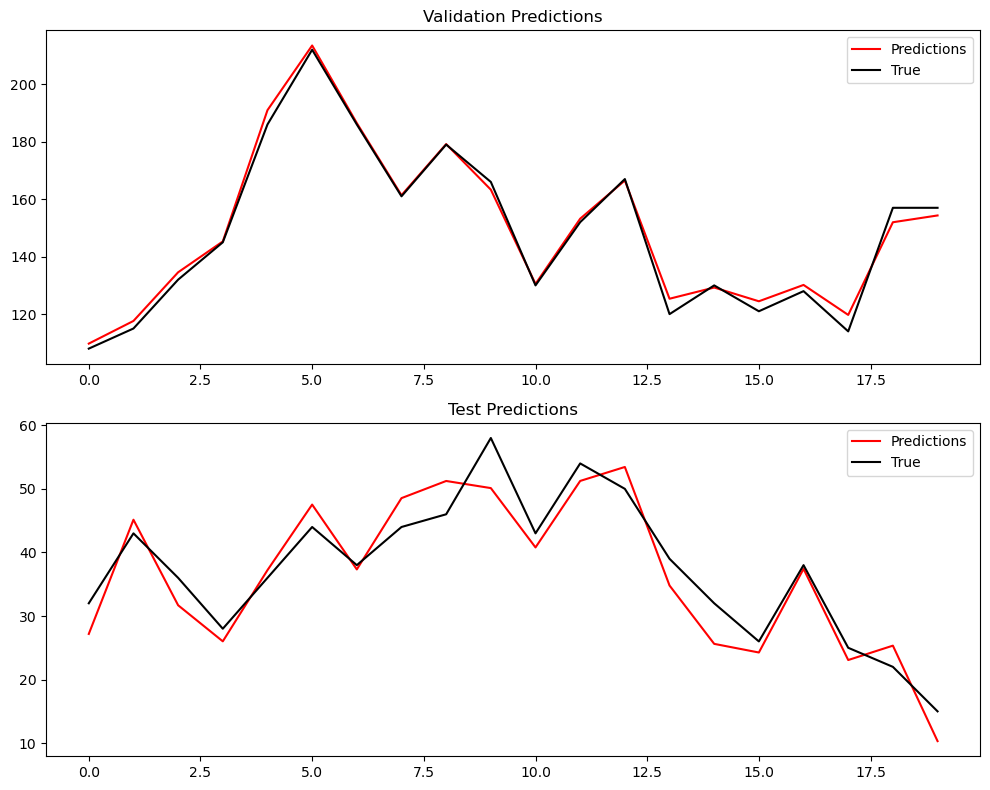

In [113]:
_,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True, 
plot_steps=20, feat_importance=False, feat_steps=15)

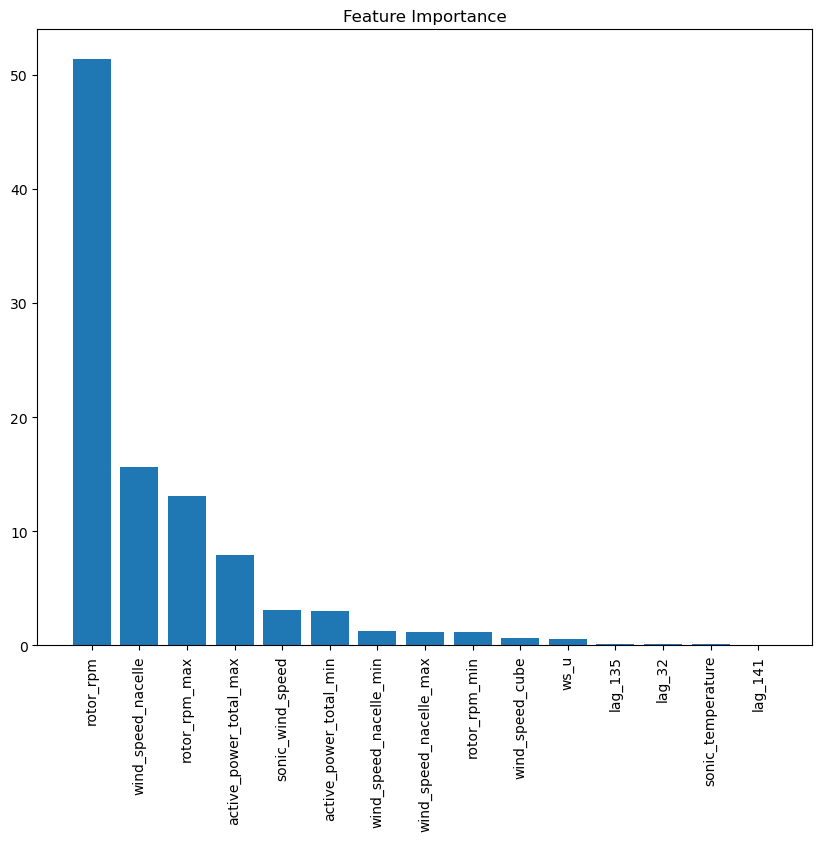

In [119]:
importances = model.model.feature_importances_

feat_steps = 15
indices = np.argsort(importances)[::-1]
names = [columns[i] for i in indices]
importances= importances[indices]

# Create plot
plt.figure(figsize=(10, 8))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(feat_steps), importances[:feat_steps])

# Add feature names as x-axis labels
plt.xticks(range(feat_steps), names[:feat_steps], rotation=90)

# Show plot
plt.show()

In [120]:

columns

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'lag_31',
 'lag_32',
 'lag_33',
 'lag_34',
 'lag_35',
 'lag_36',
 'lag_37',
 'lag_38',
 'lag_39',
 'lag_40',
 'lag_41',
 'lag_42',
 'lag_43',
 'lag_44',
 'lag_45',
 'lag_46',
 'lag_47',
 'lag_48',
 'lag_49',
 'lag_50',
 'lag_51',
 'lag_52',
 'lag_53',
 'lag_54',
 'lag_55',
 'lag_56',
 'lag_57',
 'lag_58',
 'lag_59',
 'lag_60',
 'lag_61',
 'lag_62',
 'lag_63',
 'lag_64',
 'lag_65',
 'lag_66',
 'lag_67',
 'lag_68',
 'lag_69',
 'lag_70',
 'lag_71',
 'lag_72',
 'lag_73',
 'lag_74',
 'lag_75',
 'lag_76',
 'lag_77',
 'lag_78',
 'lag_79',
 'lag_80',
 'lag_81',
 'lag_82',
 'lag_83',
 'lag_84',
 'lag_85',
 'lag_86',
 'lag_87',
 'lag_88',
 'lag_89',
 'lag_90',
 'lag_91',
 'lag_92

# Next Hour One Shot

In [35]:
train_x,val_x, test_x, train_y,val_y, test_y =dataset.create_dataset(dataset.get_df()['active_power_total'], 
                                                                     144, 6)

In [56]:
model = Model('cb')
model.train(train_x, train_y, val_x, val_y,multioutput=True)

Learning rate set to 0.06812
0:	learn: 212.0109121	total: 36ms	remaining: 36s
500:	learn: 62.9077884	total: 8.77s	remaining: 8.73s
999:	learn: 54.4520995	total: 19.8s	remaining: 0us
Learning rate set to 0.06812
0:	learn: 212.5890508	total: 65.3ms	remaining: 1m 5s
500:	learn: 73.9695359	total: 12.1s	remaining: 12s
999:	learn: 63.4336236	total: 21.9s	remaining: 0us
Learning rate set to 0.06812
0:	learn: 213.1437723	total: 60.6ms	remaining: 1m
500:	learn: 81.2937957	total: 8.23s	remaining: 8.2s
999:	learn: 69.2166055	total: 17.7s	remaining: 0us
Learning rate set to 0.06812
0:	learn: 213.1788538	total: 26.1ms	remaining: 26.1s
500:	learn: 86.2017703	total: 12.9s	remaining: 12.9s
999:	learn: 73.2072569	total: 30s	remaining: 0us
Learning rate set to 0.06812
0:	learn: 214.0739042	total: 77.8ms	remaining: 1m 17s
500:	learn: 93.0963854	total: 14.8s	remaining: 14.7s
999:	learn: 78.2469805	total: 31.9s	remaining: 0us
Learning rate set to 0.06812
0:	learn: 214.6833596	total: 85.7ms	remaining: 1m 25

                  MAE          RMSE        R2
Validation  71.478422   9541.891338  0.567783
Test        99.628366  18245.401852  0.579434


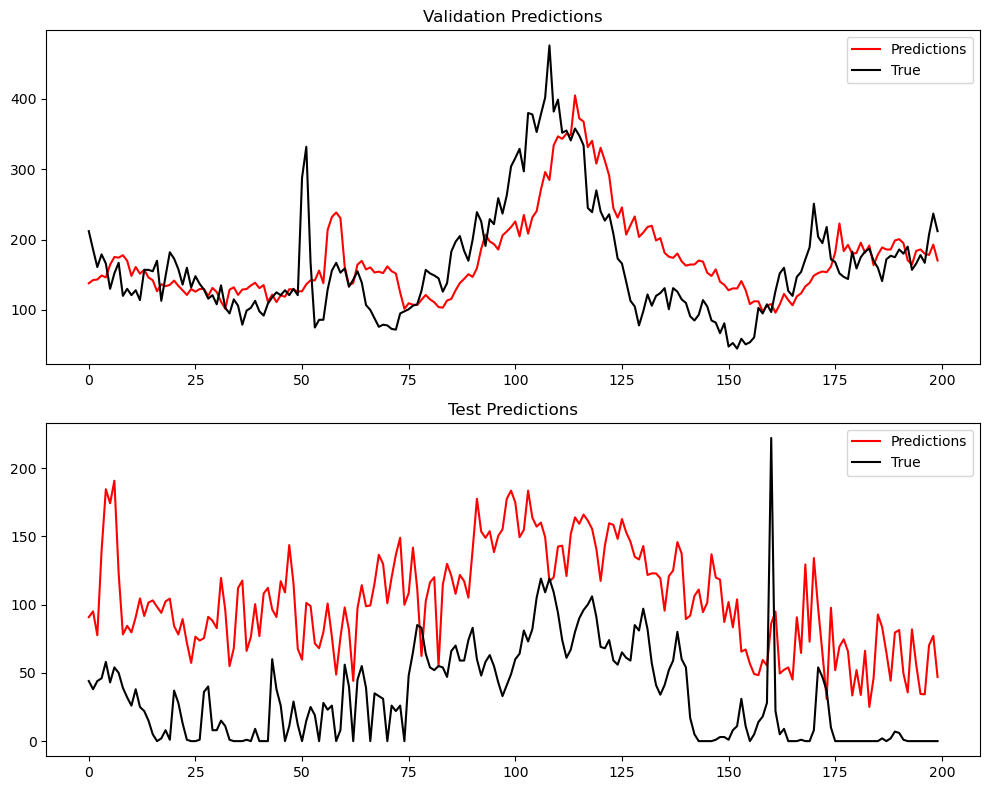

In [57]:
_,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True, 
plot_steps=200, feat_importance=False, feat_steps=15)

# Next Day One Shot

In [58]:
train_x,val_x, test_x, train_y,val_y, test_y =dataset.create_dataset(dataset.get_df()['active_power_total'], 
                                                                     144, 6*24)

In [59]:
model = Model('cb')
model.train(train_x, train_y, val_x, val_y,multioutput=True)

Learning rate set to 0.068061
0:	learn: 211.4438846	total: 35.9ms	remaining: 35.9s
500:	learn: 63.1283865	total: 8.73s	remaining: 8.7s
999:	learn: 54.5521877	total: 19.9s	remaining: 0us
Learning rate set to 0.068061
0:	learn: 212.0289922	total: 63.8ms	remaining: 1m 3s
500:	learn: 74.1186818	total: 8.91s	remaining: 8.87s
999:	learn: 63.5731755	total: 16.9s	remaining: 0us
Learning rate set to 0.068061
0:	learn: 212.6562055	total: 20ms	remaining: 20s
500:	learn: 81.5998289	total: 6.55s	remaining: 6.53s
999:	learn: 69.4522828	total: 13.6s	remaining: 0us
Learning rate set to 0.068061
0:	learn: 212.6239367	total: 34.8ms	remaining: 34.8s
500:	learn: 86.3427102	total: 7.41s	remaining: 7.38s
999:	learn: 73.3077993	total: 14.3s	remaining: 0us
Learning rate set to 0.068061
0:	learn: 213.4930144	total: 32.9ms	remaining: 32.9s
500:	learn: 93.0027081	total: 7.17s	remaining: 7.14s
999:	learn: 77.9023830	total: 15s	remaining: 0us
Learning rate set to 0.068061
0:	learn: 214.1031881	total: 27.9ms	remain

KeyboardInterrupt: 

                  MAE          RMSE        R2
Validation  71.478422   9541.891338  0.567783
Test        99.628366  18245.401852  0.579434


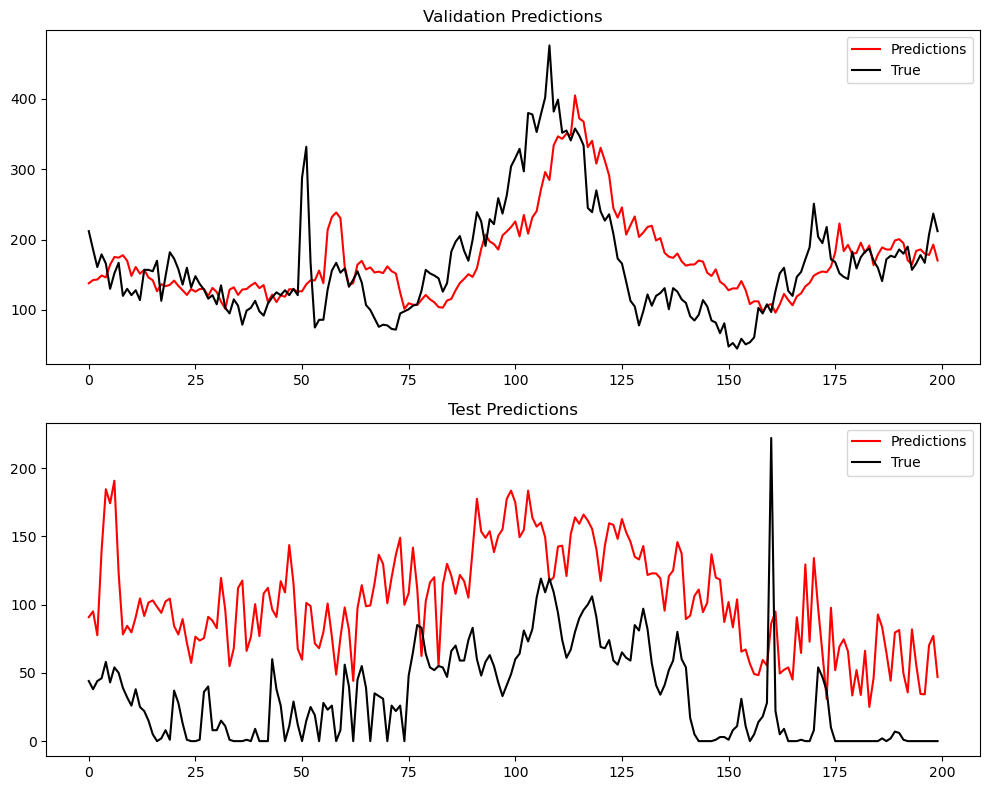

In [ ]:
_,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True, 
plot_steps=200, feat_importance=False, feat_steps=15)

# Old

In [29]:
params = {'learning_rate': 0.01,
          'objective':'RMSE',
          'use_best_model': True,
          'thread_count':8,
          'iterations': 1000,
        # 'n_estimators':500,
           'max_depth': 10,
           'objective':'RMSE',
          }

model = CatBoostRegressor(**params)

model.fit(train_x, train_y,
          eval_set = [(val_x, val_y)],
          #early_stopping_rounds = 10,
          verbose = 500)

0:	learn: 221.9639954	test: 292.1593237	best: 292.1593237 (0)	total: 122ms	remaining: 2m 2s
500:	learn: 69.8540303	test: 58.6928303	best: 58.6919116 (499)	total: 1m 1s	remaining: 1m 1s
999:	learn: 64.0667721	test: 57.5334592	best: 57.5334592 (999)	total: 1m 58s	remaining: 0us

bestTest = 57.5334592
bestIteration = 999



  Catboost MAE: 53.6738
  Catboost RMSE: 77.0668


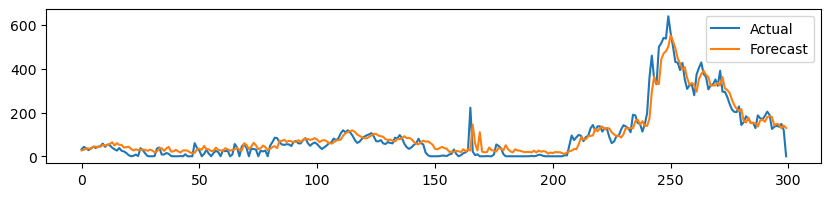

In [31]:
forecast = model.predict(test_x)



print('  Catboost MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  Catboost RMSE: %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

forecast_index = np.arange(len(forecast))
forecast = pd.DataFrame({'forecast': forecast}, index=forecast_index)

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plt.plot(test_y[:300], label = 'Actual')
plt.plot(forecast[:300], label = 'Forecast')
plt.legend()
plt.show()

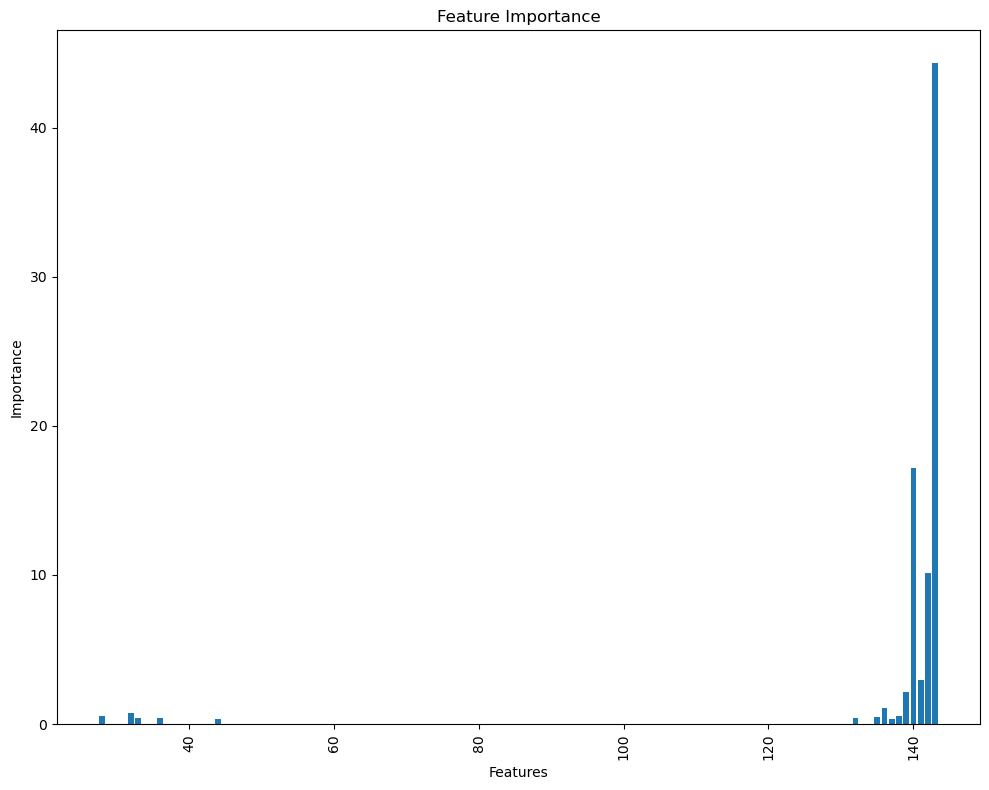

In [21]:
# window_size = 6*24
# feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]
# feature_importance = model.get_feature_importance()
# # sort the feature importance values in descending order
# idx_sorted = np.argsort(feature_importance)[::-1]

# # Create a bar plot of feature importance
# plt.figure(figsize=(10, 8))

# plt.bar(idx_sorted[:15], feature_importance[idx_sorted[:15]])
# plt.xticks(rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title(f'Feature Importance')
# plt.tight_layout()
# plt.show()

## 1 H prediction

In [11]:
window_size = 144
prediction_horizon = 6

train_x,val_x, test_x, train_y,val_y, test_y =dataset.create_dataset(dataset.get_df()['active_power_total'], window_size, prediction_horizon)

In [38]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((25081, 144), (25081, 6), (8404, 144), (8404, 6))

In [16]:
from sklearn.multioutput import MultiOutputRegressor

params = {'learning_rate': 0.01,
          'objective':'RMSE',
          'use_best_model': True,
          'thread_count':8,
          'iterations': 1000,
        # 'n_estimators':500,
           'max_depth': 10,
           'objective':'MultiRMSE',
          }

model = MultiOutputRegressor(CatBoostRegressor(), n_jobs = -1)

model.fit(train_x, train_y,)

Learning rate set to 0.06812
Learning rate set to 0.06812
Learning rate set to 0.06812
Learning rate set to 0.06812
Learning rate set to 0.06812
0:	learn: 214.6833596	total: 130ms	remaining: 2m 9s
0:	learn: 212.5890508	total: 190ms	remaining: 3m 10s
1:	learn: 206.3884997	total: 248ms	remaining: 2m 3s
0:	learn: 213.1437723	total: 221ms	remaining: 3m 41s
0:	learn: 212.0109121	total: 229ms	remaining: 3m 48s
0:	learn: 214.0739042	total: 257ms	remaining: 4m 16s
1:	learn: 202.2420844	total: 358ms	remaining: 2m 58s
2:	learn: 198.9120289	total: 420ms	remaining: 2m 19s
1:	learn: 201.0843049	total: 369ms	remaining: 3m 3s
1:	learn: 203.2733910	total: 356ms	remaining: 2m 57s
1:	learn: 205.5368384	total: 419ms	remaining: 3m 29s
2:	learn: 192.5959226	total: 486ms	remaining: 2m 41s
2:	learn: 193.8902603	total: 474ms	remaining: 2m 37s
3:	learn: 192.0776148	total: 579ms	remaining: 2m 24s
2:	learn: 190.6372160	total: 513ms	remaining: 2m 50s
2:	learn: 197.4213348	total: 535ms	remaining: 2m 57s
3:	learn: 

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f8966da7ca0>,
                     n_jobs=-1)

Multi-Step MAE: 99.6284


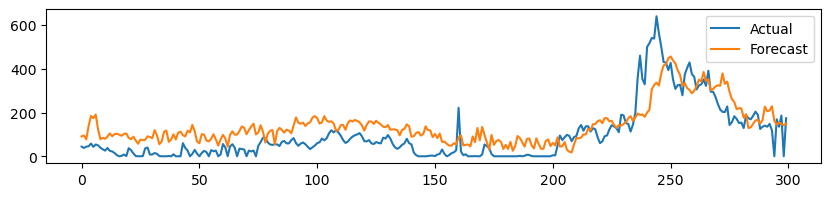

In [17]:
forecast_ms_dir= model.predict(test_x)
forecast =forecast_ms_dir[:,-1]
test_hat = test_y[:,-1]


# print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast- test_hat))))

forecast_index = np.arange(len(forecast))
forecast = pd.DataFrame({'forecast': forecast}, index=forecast_index)
# # forecast_os = pd.DataFrame({'forecast': forecast_os}, index=forecast_index)

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]


plt.plot(test_hat[:300], label = 'Actual')
plt.plot(forecast[:300], label = 'Forecast')

plt.legend()
plt.show()